# Load Libs

In [1]:
pip install --upgrade onnx onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os 
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import onnx

# Shaping tha Dataset

In [3]:
class ShapesDataset(Dataset):

    
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_folders = ['class0', 'class1', 'class2']
        self.class_names = ['Square', 'Triangle', 'Circle']
        
        print(f"csv shape: {self.labels_df.shape}")
        print(f"csv columns: {self.labels_df.columns.tolist()}")


    
    def __len__(self):
        return len(self.labels_df)



    
    def __getitem__(self, idx):
        img_name = str(self.labels_df.iloc[idx, 0])
        label = int(self.labels_df.iloc[idx, 1])
        
        folder_name = self.class_folders[label]
        img_path = os.path.join(self.img_dir, folder_name, img_name)
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transform and import data 

In [4]:
from torchvision.datasets import ImageFolder



transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




dataset = ImageFolder(root="/kaggle/input/datasets/carlodemello/shapes2/Shapes",  # so this points to the folder containing class0, class1, class2
                      transform=transform)




print(f"total images: {len(dataset)}")
print(f"classes: {dataset.classes}")
print(f"class to index: {dataset.class_to_idx}")

total images: 30001
classes: ['class0', 'class1', 'class2']
class to index: {'class0': 0, 'class1': 1, 'class2': 2}


# Labeling the data

In [5]:
from collections import Counter
labels = [label for _, label in dataset]


print(f"class distribution: {Counter(labels)}")

class distribution: Counter({2: 10001, 0: 10000, 1: 10000})


# Splitting data 

In [6]:
from torch.utils.data import random_split

train_size = 18002
test_size = len(dataset) - train_size   # here I used the ratio of 60 - 40, you can use 70 -30 or 80 -20, so a lot of r&d

if test_size < 0:
    test_size = 0
    train_size = len(dataset)

print(f"training Data: {train_size}")
print(f"test Data: {test_size}")

train_set, test_set = random_split(dataset, [train_size, test_size])

training Data: 18002
test Data: 11999


# giving batch size 

In [7]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)




print(f"train batches: {len(train_loader)}")
print(f"test batches: {len(test_loader)}")





images, labels = next(iter(train_loader))       # so this shows you the sample
print(f"batch shape: {images.shape}")
print(f"labels: {labels[:5]}")

train batches: 282
test batches: 188
batch shape: torch.Size([64, 3, 32, 32])
labels: tensor([1, 2, 1, 0, 1])


# Loading CNN model

In [8]:
class ShapesCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1),
                           nn.BatchNorm2d(32),
                           nn.ReLU(),
                           nn.MaxPool2d(2),
            
                           nn.Conv2d(32, 64, kernel_size=3, padding=1),
                           nn.BatchNorm2d(64),
                           nn.ReLU(),
                           nn.MaxPool2d(2),
            
                           nn.Conv2d(64, 128, kernel_size=3, padding=1),
                           nn.BatchNorm2d(128),
                           nn.ReLU(),
                           nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(nn.Flatten(),
                          nn.Linear(128 * 4 * 4, 256),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(128, 3))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Setting CNN model 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShapesCNN().to(device)



learning_rate = 0.0005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)



print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cpu
Model parameters: 651,523


# Assigning loader, model, loss function and optimizer

In [10]:
def train_epoch(loader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_acc = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, train_acc

In [11]:
def validate_epoch(loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, val_acc

# starting model training with given epochs as per trial basis

In [12]:
epochs = 5
best_acc = 0
patience = 5
patience_counter = 0



train_losses = []
train_accs = []
val_losses = []
val_accs = []




for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    
    train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = validate_epoch(test_loader, model, loss_fn)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'train loss: {train_loss:.4f}, train acc: {train_acc:.2f}%')
    print(f'val loss: {val_loss:.4f}, val acc: {val_acc:.2f}%')
    
    scheduler.step(val_loss)



    
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'new best model saved: {val_acc:.2f}% ***')

    
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'  early stopping after {epoch+1} epochs')
            break


Epoch 1/5
train loss: 0.9948, train acc: 46.11%
val loss: 0.8293, val acc: 57.95%
new best model saved: 57.95% ***

Epoch 2/5
train loss: 0.7111, train acc: 66.22%
val loss: 0.5377, val acc: 75.46%
new best model saved: 75.46% ***

Epoch 3/5
train loss: 0.5090, train acc: 76.11%
val loss: 0.3910, val acc: 81.73%
new best model saved: 81.73% ***

Epoch 4/5
train loss: 0.3979, train acc: 81.38%
val loss: 0.3326, val acc: 84.35%
new best model saved: 84.35% ***

Epoch 5/5
train loss: 0.3336, train acc: 84.36%
val loss: 0.3259, val acc: 84.89%
new best model saved: 84.89% ***


In [13]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

ShapesCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dro

In [14]:
all_preds = []
all_labels = []
all_probs = []



with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())




all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)




accuracy = np.mean(all_preds == all_labels) * 100
print(f"\nfinal test accuracy: {accuracy:.2f}%")


final test accuracy: 84.87%


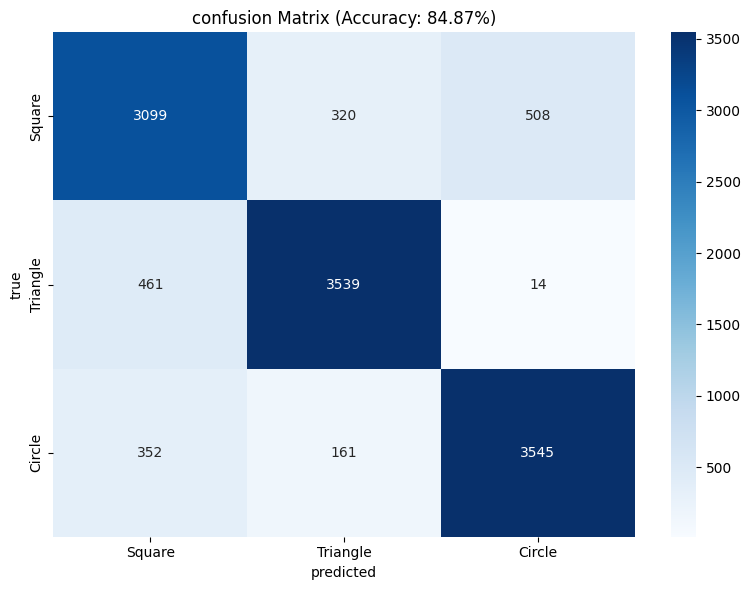

In [15]:
class_names = ['Square', 'Triangle', 'Circle']



cm = confusion_matrix(all_labels, all_preds)




plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('predicted')
plt.ylabel('true')
plt.title(f'confusion Matrix (Accuracy: {accuracy:.2f}%)')
plt.tight_layout()
plt.show()

# Classification report 

In [16]:
print("\nclassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


classification report:
              precision    recall  f1-score   support

      Square     0.7922    0.7892    0.7907      3927
    Triangle     0.8803    0.8817    0.8810      4014
      Circle     0.8716    0.8736    0.8726      4058

    accuracy                         0.8487     11999
   macro avg     0.8481    0.8481    0.8481     11999
weighted avg     0.8486    0.8487    0.8486     11999



In [17]:
correct_mask = all_preds == all_labels
correct_confidences = all_probs[correct_mask].max(axis=1)
wrong_confidences = all_probs[~correct_mask].max(axis=1)





print(f"\nconfidence analysis:")
print(f"correct predictions ({len(correct_confidences)} samples):")
print(f"  mean confidence: {correct_confidences.mean():.4f}")
print(f"  min confidence: {correct_confidences.min():.4f}")
print(f"  max confidence: {correct_confidences.max():.4f}")






if len(wrong_confidences) > 0:
    print(f"\nwrong predictions ({len(wrong_confidences)} samples):")
    print(f"  mean confidence: {wrong_confidences.mean():.4f}")
    print(f"  min confidence: {wrong_confidences.min():.4f}")
    print(f"  max confidence: {wrong_confidences.max():.4f}")


confidence analysis:
correct predictions (10183 samples):
  mean confidence: 0.9002
  min confidence: 0.3427
  max confidence: 1.0000

wrong predictions (1816 samples):
  mean confidence: 0.5502
  min confidence: 0.3441
  max confidence: 1.0000


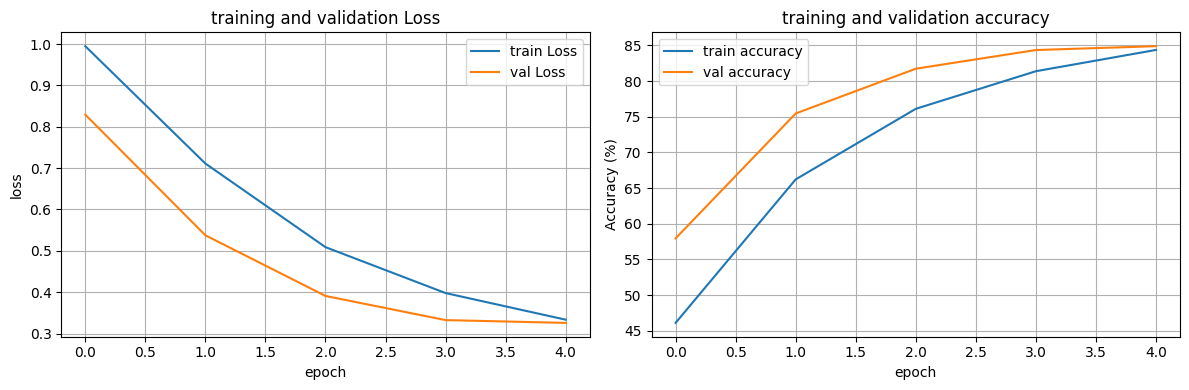

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train Loss')
plt.plot(val_losses, label='val Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training and validation Loss')
plt.legend()
plt.grid(True)



plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train accuracy')
plt.plot(val_accs, label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.title('training and validation accuracy')
plt.legend()
plt.grid(True)




plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

results_df = pd.DataFrame({'true_label': all_labels,
                           'predicted_label': all_preds,
                           'confidence': all_probs.max(axis=1),
                           'is_correct': all_preds == all_labels})


for i, class_name in enumerate(class_names):
    results_df[f'prob_{class_name}'] = all_probs[:, i]



results_df.to_csv('model_predictions.csv', index=False)
print(f"\ndetailed predictions saved to 'model_predictions.csv'")


detailed predictions saved to 'model_predictions.csv'


# load libs

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os 
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
from torchvision.datasets import ImageFolder

# transform and load data

In [21]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



dataset = ImageFolder(root="/kaggle/input/datasets/carlodemello/shapes2/Shapes",
                      transform=transform)



print(f"total images: {len(dataset)}")
print(f"classes: {dataset.classes}")
print(f"class to index: {dataset.class_to_idx}")





train_size = 18002
test_size = len(dataset) - train_size




train_set, test_set = random_split(dataset, [train_size, test_size])




batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)




print(f"\ntrain batches: {len(train_loader)}")
print(f"test batches: {len(test_loader)}")

total images: 30001
classes: ['class0', 'class1', 'class2']
class to index: {'class0': 0, 'class1': 1, 'class2': 2}

train batches: 282
test batches: 188


# ANN model 

In [22]:
class ANNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(nn.Linear(32*32*3, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
            
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
            
                                    nn.Linear(256, 128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
            
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
            
                                    nn.Linear(64, 3))

    
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

# CNN model

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
            
                                         nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
            
                                         nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
            
                                         nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))

        
        
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(256 * 2 * 2, 512),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(512, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.3),
                                        nn.Linear(256, 3))

    
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# traning loop

In [24]:
def train_model(model, train_loader, test_loader, model_name, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"training {model_name}")



    
    model = model.to(device)
    
    learning_rate = 0.001
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    training_time = 0


    
    best_acc = 0
    best_model_state = None


    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0



        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        epoch_time = time.time() - start_time
        training_time += epoch_time
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0



        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100. * val_correct / val_total
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)




        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'epoch {epoch+1}/{epochs} | time: {epoch_time:.1f}s')
        print(f'  train Loss: {train_loss:.4f} | train Acc: {train_acc:.2f}%')
        print(f'  val Loss:  {val_loss:.4f} | val Acc:  {val_acc:.2f}%')




    
    model.load_state_dict(best_model_state)
    
    torch.save(model.state_dict(), f'{model_name}_best.pth')
    
    results = {'model_name': model_name,
               'train_losses': train_losses,
               'train_accs': train_accs,
               'val_losses': val_losses,
               'val_accs': val_accs,
               'best_val_acc': best_acc,
               'training_time': training_time,
               'model': model,
               'params': sum(p.numel() for p in model.parameters() if p.requires_grad)}



    
    
    print(f"\nbest validation accuracy: {best_acc:.2f}%")
    print(f"total training time: {training_time:.1f}s")
    print(f"trainable parameters: {results['params']:,}")
    
    return results

# testing loop

In [25]:
def evaluate_model(model, test_loader, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()


    
    all_preds = []
    all_labels = []
    all_probs = []



    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)



    
    accuracy = np.mean(all_preds == all_labels) * 100
    
    correct_mask = all_preds == all_labels
    correct_confidences = np.array(all_probs)[correct_mask].max(axis=1)


    
    evaluation = {'accuracy': accuracy,
                  'predictions': all_preds,
                  'labels': all_labels,
                  'probs': all_probs,
                  'avg_confidence': correct_confidences.mean() if len(correct_confidences) > 0 else 0}

    
    return evaluation

# plotting the model

In [26]:
def plot_training_history(results):
    model_name = results['model_name']


    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)




    
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accs'], label='Train Accuracy')
    plt.plot(results['val_accs'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run ANN model

training ANN
epoch 1/5 | time: 21.1s
  train Loss: 1.0986 | train Acc: 35.33%
  val Loss:  1.0617 | val Acc:  38.97%
epoch 2/5 | time: 22.0s
  train Loss: 1.0394 | train Acc: 42.04%
  val Loss:  1.0135 | val Acc:  45.25%
epoch 3/5 | time: 21.7s
  train Loss: 0.9982 | train Acc: 46.53%
  val Loss:  0.9499 | val Acc:  51.18%
epoch 4/5 | time: 21.1s
  train Loss: 0.9685 | train Acc: 49.11%
  val Loss:  0.9389 | val Acc:  52.59%
epoch 5/5 | time: 21.2s
  train Loss: 0.9491 | train Acc: 50.76%
  val Loss:  0.9170 | val Acc:  53.15%

best validation accuracy: 53.15%
total training time: 107.0s
trainable parameters: 1,746,051


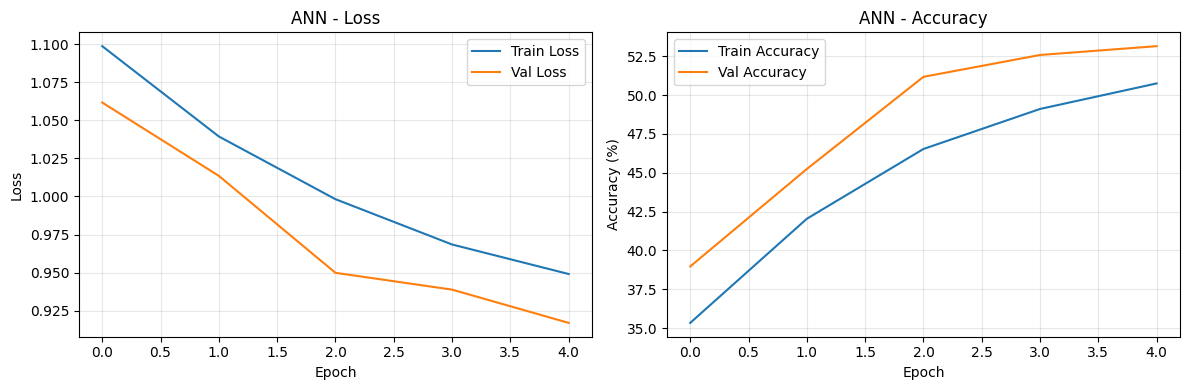

In [27]:
ann_model = ANNModel()
ann_results = train_model(ann_model, train_loader, test_loader, "ANN", epochs=5)
plot_training_history(ann_results)

# Run CNN model

training CNN
epoch 1/5 | time: 44.3s
  train Loss: 0.9845 | train Acc: 46.32%
  val Loss:  0.5705 | val Acc:  74.60%
epoch 2/5 | time: 44.0s
  train Loss: 0.3528 | train Acc: 83.70%
  val Loss:  0.1994 | val Acc:  91.55%
epoch 3/5 | time: 45.6s
  train Loss: 0.2040 | train Acc: 91.07%
  val Loss:  0.1389 | val Acc:  93.87%
epoch 4/5 | time: 45.3s
  train Loss: 0.1456 | train Acc: 94.13%
  val Loss:  0.1061 | val Acc:  95.48%
epoch 5/5 | time: 45.4s
  train Loss: 0.1390 | train Acc: 94.25%
  val Loss:  0.0861 | val Acc:  96.29%

best validation accuracy: 96.29%
total training time: 224.5s
trainable parameters: 1,046,275


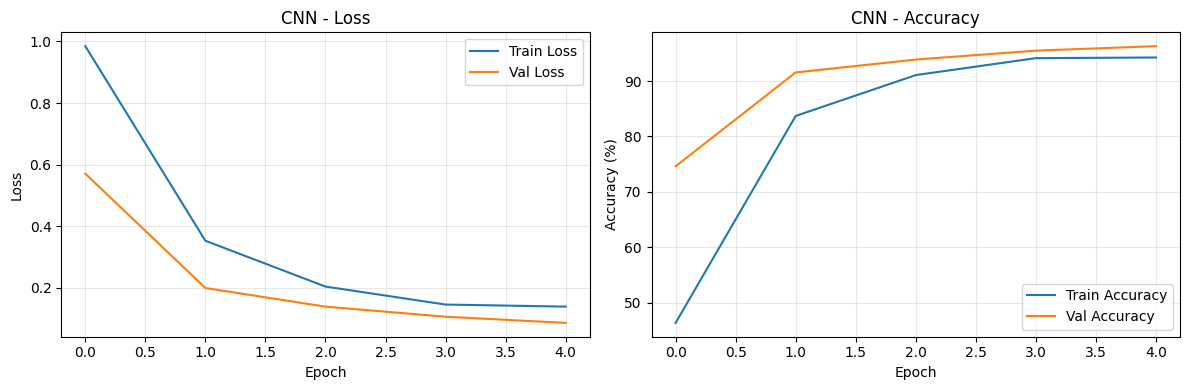

In [28]:
cnn_model = CNNModel()
cnn_results = train_model(cnn_model, train_loader, test_loader, "CNN", epochs=5)
plot_training_history(cnn_results)

In [29]:
torch_model = CNNModel()
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(3, 3, 32, 32),)
onnx_program = torch.onnx.export(torch_model, example_inputs, dynamo=True)
onnx_program.save("image_classifier_model.onnx")

W0213 13:08:32.469000 17 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0213 13:08:32.471000 17 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0213 13:08:32.474000 17 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.
W0213 13:08:32.476000 17 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.


[torch.onnx] Obtain model graph for `CNNModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CNNModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.


In [30]:
ann_eval = evaluate_model(ann_results['model'], test_loader, "ANN")
cnn_eval = evaluate_model(cnn_results['model'], test_loader, "CNN")





print(f"\nann model:")
print(f"  test Accuracy: {ann_eval['accuracy']:.2f}%")
print(f"  best Val Accuracy: {ann_results['best_val_acc']:.2f}%")
print(f"  training Time: {ann_results['training_time']:.1f}s")
print(f"  parameters: {ann_results['params']:,}")
print(f"  avg Confidence: {ann_eval['avg_confidence']:.4f}")



print(f"\ncnn model:")
print(f"  test Accuracy: {cnn_eval['accuracy']:.2f}%")
print(f"  best Val Accuracy: {cnn_results['best_val_acc']:.2f}%")
print(f"  training Time: {cnn_results['training_time']:.1f}s")
print(f"  parameters: {cnn_results['params']:,}")
print(f"  avg Confidence: {cnn_eval['avg_confidence']:.4f}")




print(f"\ncomparison:")
print(f"  accuracy Difference: {cnn_eval['accuracy'] - ann_eval['accuracy']:.2f}%")
print(f"  time Difference: {cnn_results['training_time'] - ann_results['training_time']:.1f}s")
print(f"  parameter Ratio: {cnn_results['params']/ann_results['params']:.2f}x")


ann model:
  test Accuracy: 53.15%
  best Val Accuracy: 53.15%
  training Time: 107.0s
  parameters: 1,746,051
  avg Confidence: 0.5560

cnn model:
  test Accuracy: 96.29%
  best Val Accuracy: 96.29%
  training Time: 224.5s
  parameters: 1,046,275
  avg Confidence: 0.9718

comparison:
  accuracy Difference: 43.14%
  time Difference: 117.5s
  parameter Ratio: 0.60x


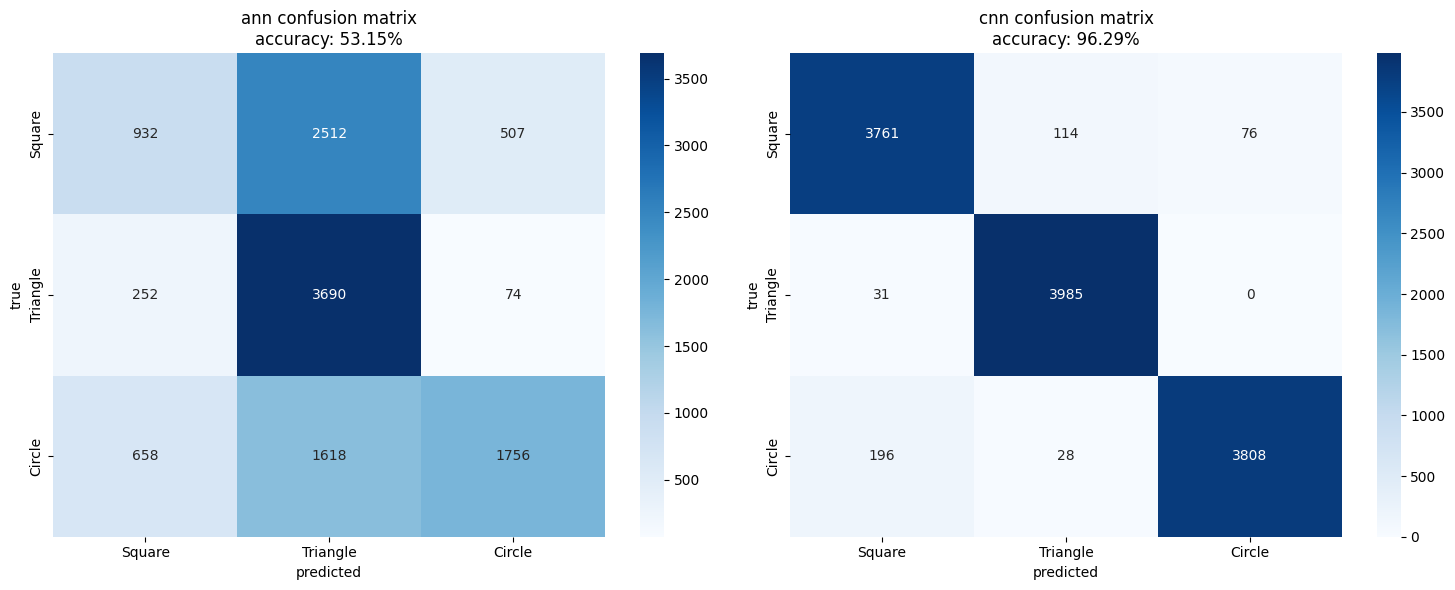

In [31]:
class_names = ['Square', 'Triangle', 'Circle']




fig, axes = plt.subplots(1, 2, figsize=(15, 6))



ann_cm = confusion_matrix(ann_eval['labels'], ann_eval['predictions'])
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('true')
axes[0].set_title(f'ann confusion matrix\naccuracy: {ann_eval["accuracy"]:.2f}%')




cnn_cm = confusion_matrix(cnn_eval['labels'], cnn_eval['predictions'])
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('predicted')
axes[1].set_ylabel('true')
axes[1].set_title(f'cnn confusion matrix\naccuracy: {cnn_eval["accuracy"]:.2f}%')





plt.tight_layout()
plt.show()

# classification report of both model 

In [32]:

print("ann classification report")

print(classification_report(ann_eval['labels'], ann_eval['predictions'], 
                          target_names=class_names, digits=4))


print("cnn classification report")

print(classification_report(cnn_eval['labels'], cnn_eval['predictions'], 
                          target_names=class_names, digits=4))

ann classification report
              precision    recall  f1-score   support

      Square     0.5060    0.2359    0.3218      3951
    Triangle     0.4719    0.9188    0.6235      4016
      Circle     0.7514    0.4355    0.5514      4032

    accuracy                         0.5315     11999
   macro avg     0.5764    0.5301    0.4989     11999
weighted avg     0.5770    0.5315    0.4999     11999

cnn classification report
              precision    recall  f1-score   support

      Square     0.9431    0.9519    0.9475      3951
    Triangle     0.9656    0.9923    0.9788      4016
      Circle     0.9804    0.9444    0.9621      4032

    accuracy                         0.9629     11999
   macro avg     0.9630    0.9629    0.9628     11999
weighted avg     0.9632    0.9629    0.9629     11999



# multiple plots 

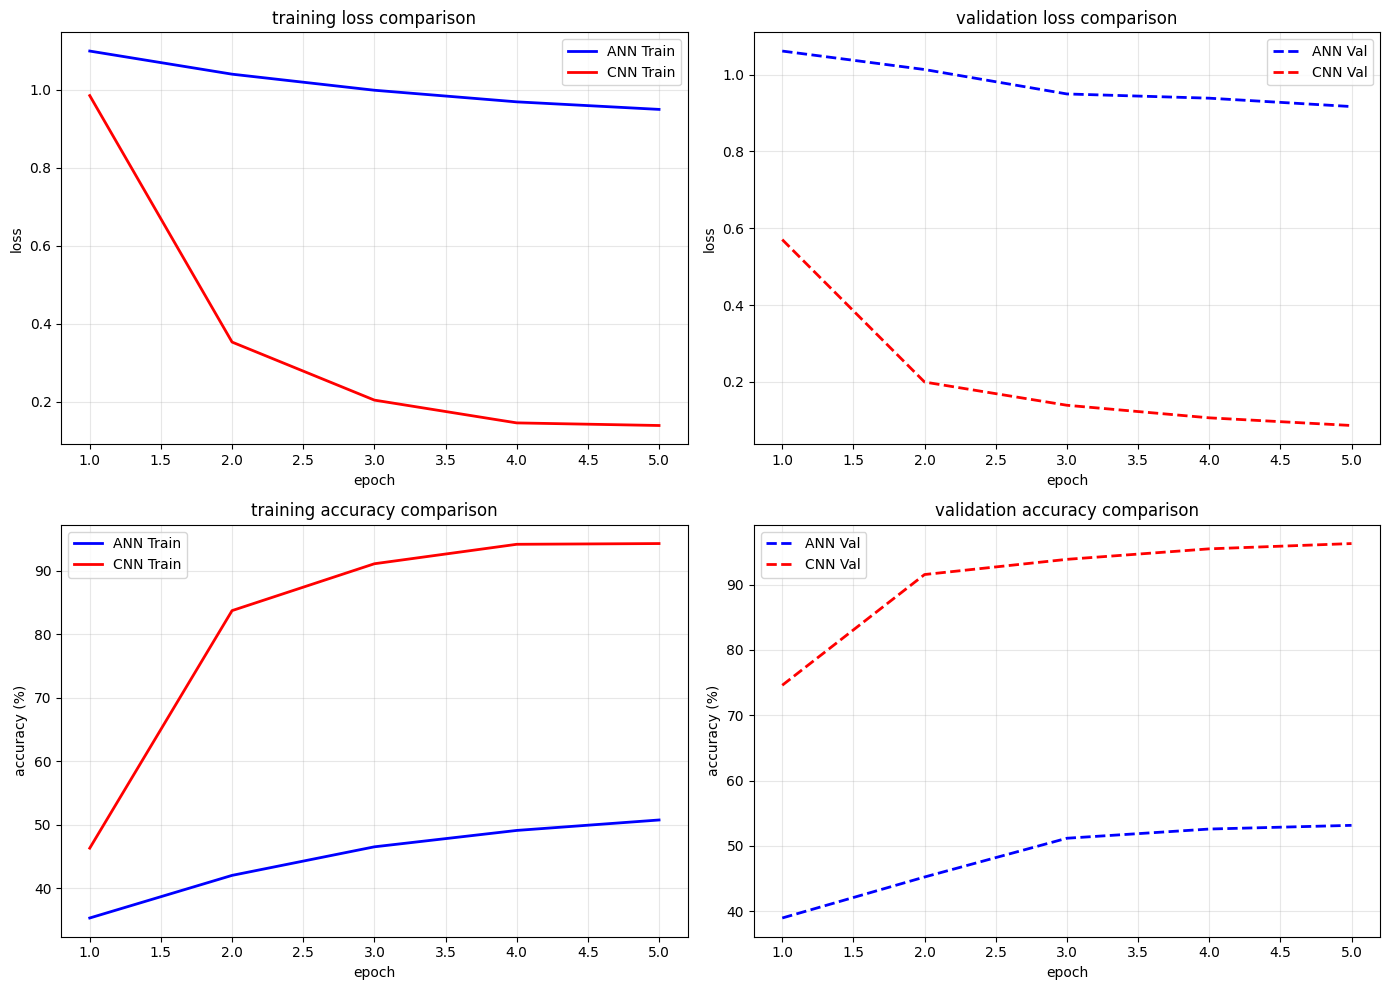

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(ann_results['train_losses']) + 1)

axes[0, 0].plot(epochs_range, ann_results['train_losses'], 'b-', label='ANN Train', linewidth=2)
axes[0, 0].plot(epochs_range, cnn_results['train_losses'], 'r-', label='CNN Train', linewidth=2)
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].set_title('training loss comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)



axes[0, 1].plot(epochs_range, ann_results['val_losses'], 'b--', label='ANN Val', linewidth=2)
axes[0, 1].plot(epochs_range, cnn_results['val_losses'], 'r--', label='CNN Val', linewidth=2)
axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_ylabel('loss')
axes[0, 1].set_title('validation loss comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)




axes[1, 0].plot(epochs_range, ann_results['train_accs'], 'b-', label='ANN Train', linewidth=2)
axes[1, 0].plot(epochs_range, cnn_results['train_accs'], 'r-', label='CNN Train', linewidth=2)
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_ylabel('accuracy (%)')
axes[1, 0].set_title('training accuracy comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)



axes[1, 1].plot(epochs_range, ann_results['val_accs'], 'b--', label='ANN Val', linewidth=2)
axes[1, 1].plot(epochs_range, cnn_results['val_accs'], 'r--', label='CNN Val', linewidth=2)
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_ylabel('accuracy (%)')
axes[1, 1].set_title('validation accuracy comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

# different evaluation matrics 

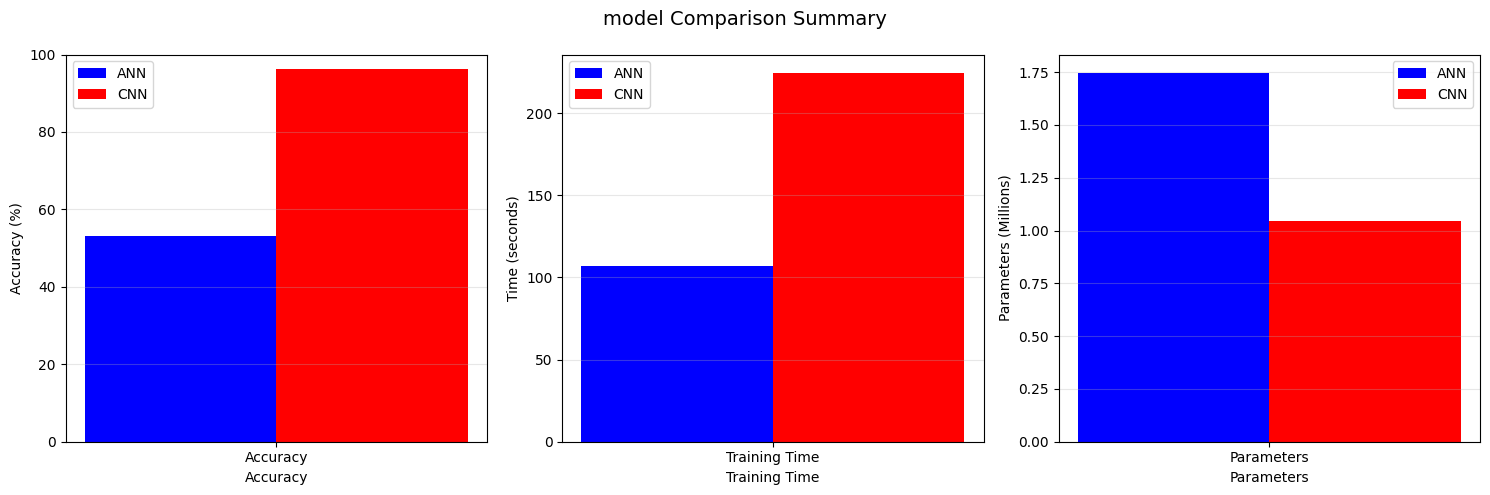

In [34]:
metrics = ['Accuracy', 'Training Time', 'Parameters']
ann_values = [ann_eval['accuracy'], ann_results['training_time'], ann_results['params']/1e6]
cnn_values = [cnn_eval['accuracy'], cnn_results['training_time'], cnn_results['params']/1e6]



x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(1, 3, figsize=(15, 5))





for i, metric in enumerate(metrics):
    ax[i].bar(x[i] - width/2, ann_values[i], width, label='ANN', color='blue')
    ax[i].bar(x[i] + width/2, cnn_values[i], width, label='CNN', color='red')
    ax[i].set_xlabel(metric)
    
    if metric == 'Accuracy':
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([0, 100])
    elif metric == 'Training Time':
        ax[i].set_ylabel('Time (seconds)')
    else:
        ax[i].set_ylabel('Parameters (Millions)')
    
    ax[i].set_xticks([x[i]])
    ax[i].set_xticklabels([metric])
    ax[i].legend()
    ax[i].grid(True, alpha=0.3, axis='y')





plt.suptitle('model Comparison Summary', fontsize=14)
plt.tight_layout()
plt.show()

# Saving in detailed result in df 

In [35]:
results_summary = pd.DataFrame({'Model': ['ANN', 'CNN'],
                                'Test_Accuracy': [ann_eval['accuracy'], cnn_eval['accuracy']],
                                'Best_Val_Accuracy': [ann_results['best_val_acc'], cnn_results['best_val_acc']],
                                'Training_Time_s': [ann_results['training_time'], cnn_results['training_time']],
                                'Parameters': [ann_results['params'], cnn_results['params']],
                                'Avg_Confidence': [ann_eval['avg_confidence'], cnn_eval['avg_confidence']]})





print(results_summary.to_string(index=False))




results_summary.to_csv('model_comparison_results.csv', index=False)

Model  Test_Accuracy  Best_Val_Accuracy  Training_Time_s  Parameters  Avg_Confidence
  ANN      53.154430          53.154430       107.024602     1746051        0.556043
  CNN      96.291358          96.291358       224.493090     1046275        0.971838


In [36]:
output = pd.read_csv("model_comparison_results.csv")
output

,Model,Test_Accuracy,Best_Val_Accuracy,Training_Time_s,Parameters,Avg_Confidence
0,ANN,53.154430,53.154430,107.024602,1746051,0.556043
1,CNN,96.291358,96.291358,224.493090,1046275,0.971838
